In [1]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,InceptionV3,ResNet50, MobileNetV2
from keras.applications.vgg16 import preprocess_input
#from keras.applications.mobilenetv2 import preprocess_input
#from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.layers import AveragePooling2D, Dropout,Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd
from PIL import Image

In [3]:
train_path = "/Users/harshpanwar/Desktop/Research_Work/COVID/train"
test_path = "/Users/harshpanwar/Desktop/Research_Work/COVID/test"

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
 rotation_range=20,
 featurewise_center = True,
 featurewise_std_normalization = True,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.25,
 zoom_range=0.1,
 zca_whitening = True,
 channel_shift_range = 20,
 horizontal_flip = True ,
 vertical_flip = True ,
 validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

/Users/harshpanwar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [5]:
train_generator = train_datagen.flow_from_directory(train_path,
    target_size = (224, 224),
    shuffle=True,seed=42,class_mode="categorical",
    color_mode = 'rgb',
    batch_size = 16)
test_generator = test_datagen.flow_from_directory(test_path,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)

Found 200 images belonging to 2 classes.
Found 84 images belonging to 2 classes.


/Users/harshpanwar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/harshpanwar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


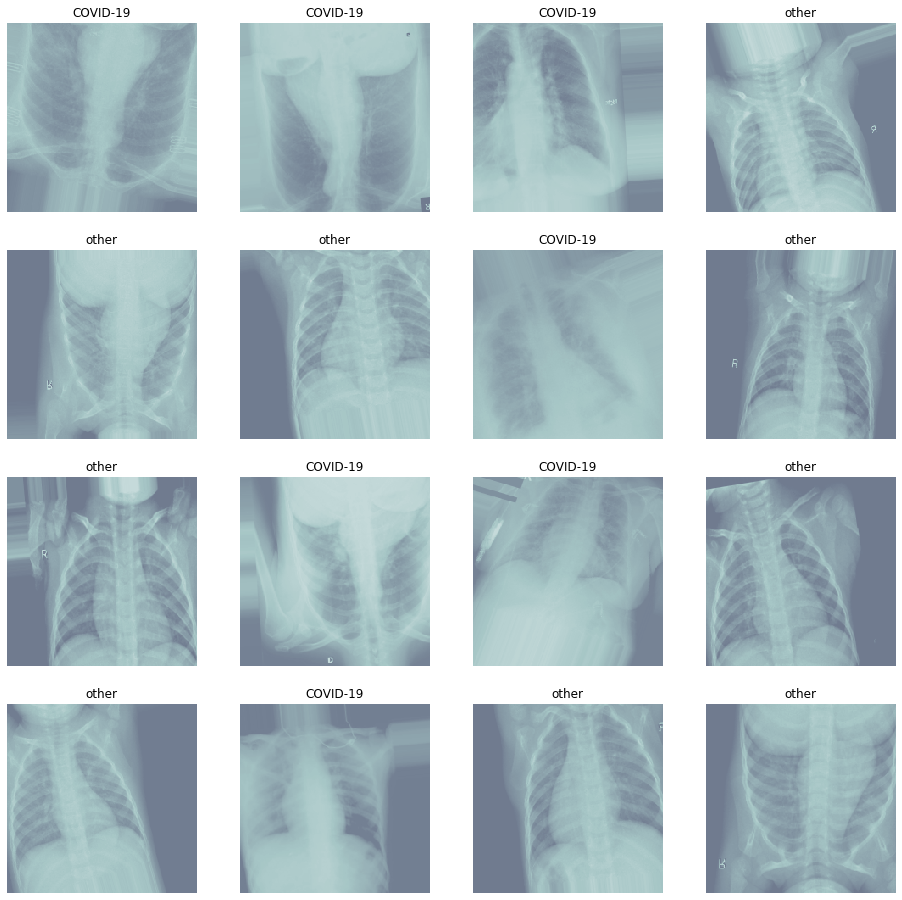

In [6]:
all_labels = ['COVID-19','other']
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [7]:
basemodel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [8]:
headModel = basemodel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)#pool_size=(4, 4)
headModel = Flatten(name="flatten")(headModel)
#headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
#headModel = Dense(256, activation="relu")(headModel)
#headModel = Dropout(0.3)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [9]:
model = Model(inputs=basemodel.input, outputs=headModel)

In [10]:
for layer in basemodel.layers:
    layer.trainable = False

In [14]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 16

In [12]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [15]:
print("[INFO] training head...")
H = model.fit_generator(
	train_generator,
	steps_per_epoch=200 // BS,
	validation_data=test_generator,
	validation_steps=84 // BS,
	epochs=EPOCHS)


[INFO] training head...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 12 steps, validate for 5 steps
Epoch 1/25
12/12 [==============================] - 41s 3s/step - loss: 0.4084 - accuracy: 0.8152 - val_loss: 0.1658 - val_accuracy: 1.0000
Epoch 2/25
12/12 [==============================] - 42s 4s/step - loss: 0.3277 - accuracy: 0.8859 - val_loss: 0.1015 - val_accuracy: 1.0000
Epoch 3/25
12/12 [==============================] - 42s 3s/step - loss: 0.2876 - accuracy: 0.8913 - val_loss: 0.0653 - val_accuracy: 1.0000
Epoch 4/25
12/12 [==============================] - 41s 3s/step - loss: 0.2290 - accuracy: 0.9239 - val_loss: 0.0838 - val_accuracy: 1.0000
Epoch 5/25
12/12 [==============================] - 47s 4s/step - loss: 0.2613 - accuracy: 0.9185 - val_loss: 0.0408 - val_accuracy: 1.0000
Epoch 6/25
12/12 [==============================] - 47s 4s/step - loss: 0.1833 - accuracy: 0.9375 - val_loss: 0.0663 - val_accuracy: 1.0000
Epoch 7/25
12/12 [===========================

In [40]:
model.save('/Users/harshpanwar/Desktop/Research_Work/COVID/Covid_Binary.h5')